In [3]:
from sqlalchemy import create_engine, inspect,func
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
from sqlalchemy import Column, Integer, String, Float, DateTime
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [4]:
engine = create_engine("sqlite:///hawaii.sqlite")
# inspector = inspect(engine)
Base.prepare(engine,reflect = True)

In [5]:
from sqlalchemy.orm import Session
session = Session(bind = engine)
# inspector.get_table_names()
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station


In [6]:
first_data = session.query(Measurement).first()
first_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10b9043c8>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [7]:
precip_data = session.query(Station).first()
precip_data.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x10b91a2b0>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [8]:
query_date = session.query(Measurement.date).order_by((Measurement.date).desc()).first()
query_date


('2017-08-23')

In [9]:
days_ago = query_date = dt.date(2017,8,23) - dt.timedelta(days = 366)
days_ago

datetime.date(2016, 8, 22)

In [10]:
#Design a query to retrieve the last 12 months of precipitation data.
prcp = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>days_ago).all()
prcp_df = pd.DataFrame(prcp, columns = ["Date", "Precipitation"])
prcp_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


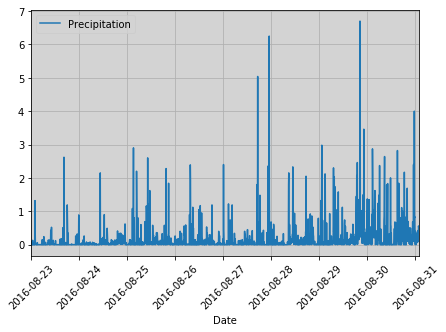

In [55]:
graph = prcp_df.plot()
plt.tight_layout()
plt.grid(True)
graph.set_xticklabels(prcp_df["Date"], rotation=45)
plt.xlabel("Date")
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.show()

In [28]:
#Design a query to calculate the total number of stations.
total_stations = session.query(Station.station).count()
total_stations

9

In [39]:
# Design a query to find the most active stations.
sel = [Station.name, Measurement.station, func.count(Measurement.tobs)]
active = session.query(*sel).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
active

('WAIHEE 837.5, HI US', 'USC00519281', 2772)

In [56]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
tobs = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>days_ago).filter(Measurement.station == active[1]).all()
tobs_df = pd.DataFrame(tobs,columns=["date","tobs"])
tobs_df.head()

,date,tobs
0,2016-08-23,77
1,2016-08-24,77
2,2016-08-25,80
3,2016-08-26,80
4,2016-08-27,75


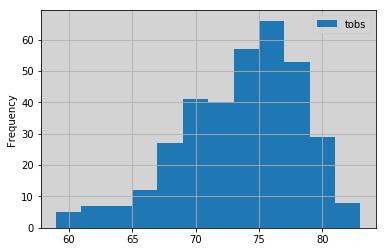

In [57]:
# Plot the results as a histogram with bins=12
tobs_df.plot.hist(bins = 12)
plt.grid(True)
plt.show()

[datetime.date(2017, 7, 24), datetime.date(2017, 8, 6)]


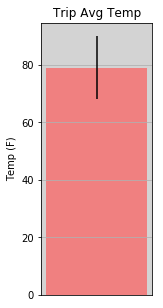

In [182]:
from scipy.stats import sem
def calc_temps(start_date, end_date):
    dates = [start_date, end_date]
    last_year_date=[]
    for x in range(len(dates)):
        split_start_date = dates[x].split("-")
        last_year_date.append(dt.date(int(split_start_date[0]),int(split_start_date[1]),int(split_start_date[2]))-dt.timedelta(days = 365))
    print(last_year_date)
                              
    temperature = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs))\
    .filter(Measurement.date >= last_year_date[0]).filter(Measurement.date<=last_year_date[1]).all()
    temp = list(np.ravel(temperature))
    
    plt.figure(figsize = (2,5))
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.bar(1, temp[1], color = "lightcoral",yerr = (temp[2] - temp[0]),tick_label = "")
    plt.grid()
    plt.xticks([])
    plt.show()

calc_temps("2018-07-24","2018-08-06")


In [189]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
# def tem(start,end):
sel = [func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)]
temperatures = session.query(*sel).filter(Measurement.date >="2016-08-23" ).filter(Measurement.date<="2016-08-27" ).all()

print(temperatures)
# tem("8//1/17","9/1/17")

[(84, 73, 78.63333333333334)]


In [102]:
# Create a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic tobs that match that date string.
def daily_normals(query_date):
    temperature = session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.date.like(f"%{query_date}")).all()
    t_list = list(np.ravel(temperature))
    tempp = [t_list[1],t_list[0],t_list[2]] 
    return tempp
daily_normals("07-24")

[69.0, 81.0, 76.400000000000006]

In [137]:
start_date = "2017-07-24"
end_date = "2017-08-06"

day_range = pd.date_range(start_date,end_date,freq = "D")
results = {}
for d in list(day_range):
    date_list=d.strftime("%m-%d")
    results[date_list]=daily_normals(date_list)
# df = pd.DataFrame(results[0],columns = )
df = pd.DataFrame(results).T
df.columns = ["Maximum", "Minimum", "Average"]
df.head()


,Maximum,Minimum,Average
07-24,69.0,81.0,76.400000
07-25,67.0,84.0,76.941176
07-26,71.0,86.0,76.411765
07-27,68.0,83.0,76.367347
07-28,69.0,82.0,76.452830


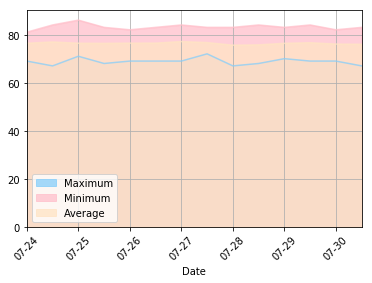

In [164]:
df_plot = df.plot(kind = 'area', stacked = False, alpha = 0.75, color = ['lightskyblue','pink','bisque'])
plt.grid()
plt.xlabel("Date")
df1 = df.reset_index()
df_plot.set_xticklabels(df1["index"], rotation=45)
plt.show()